In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import os
import sys
from pathlib import Path
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [14]:
def load_csv_from_project_root(relative_path: str, project_root: str = r'C:/Users/kau75421/LLMprojects/CreditFraudDetection') -> pd.DataFrame:
    """
    Load a CSV file using a path relative to the project root.

    Parameters:
    - relative_path: str, relative path to the CSV file from the project root
    - project_root: str, full path to the project root directory

    Returns:
    - pd.DataFrame: Loaded DataFrame
    """
    root = Path(project_root)
    csv_path = root / relative_path
    return pd.read_csv(csv_path)

# Example usage:
df = load_csv_from_project_root('data/processed/Bank_Transaction_Fraud_Detection_Processed.csv')
df.head()

,Customer_ID,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_Date,Transaction_Time,Transaction_Amount,...,Balance_After_Transaction,Amount_Per_Balance,Is_Large_Transaction,Daily_Spend,Age_Group,Is_Senior,Is_Youth,Device_Hour_Anomaly,User_Home_City,Device_Location_Mismatch
0,1.165800,0.99549,1.045534,-0.156418,1.344112,Thiruvananthapuram Branch,1.225254,0.862982,0.590639,-0.599702,...,0.990801,-0.402078,0.0,-0.599702,0.0,0.0,0.0,0.0,1.344112,0.0
1,-0.051277,-1.00453,0.456865,0.149618,0.699465,Nashik Branch,-1.226603,-0.520739,0.760190,-0.207182,...,0.709487,-0.283822,0.0,-0.207182,0.0,0.0,0.0,0.0,0.699465,0.0
2,-0.943509,0.99549,-1.570771,-1.278547,-1.377733,Bhagalpur Branch,1.225254,1.093603,-1.275184,0.473684,...,0.021599,-0.000252,0.0,0.473684,1.0,0.0,1.0,1.0,-1.377733,0.0
3,-0.092154,-1.00453,0.849311,1.169735,-1.162850,Chennai Branch,-1.226603,0.401742,0.065951,-1.244660,...,1.042170,-0.555313,0.0,-1.244660,0.0,0.0,0.0,0.0,-1.162850,0.0
4,-0.945760,-1.00453,-0.066396,0.863700,-1.520988,Amritsar Branch,1.225254,1.670153,0.942524,-1.092851,...,-0.129439,0.153230,0.0,-1.092851,0.0,0.0,0.0,0.0,-1.520988,0.0


In [15]:
df =  df.drop(columns='Bank_Branch')
df.columns

Index(['Customer_ID', 'Gender', 'Age', 'State', 'City', 'Account_Type',
       'Transaction_Date', 'Transaction_Time', 'Transaction_Amount',
       'Merchant_ID', 'Transaction_Type', 'Merchant_Category',
       'Account_Balance', 'Transaction_Device', 'Transaction_Location',
       'Device_Type', 'Is_Fraud', 'Transaction_Currency',
       'Transaction_Description', 'Transaction_Hour', 'HourOfDay', 'Is_Night',
       'Is_Weekend', 'Balance_After_Transaction', 'Amount_Per_Balance',
       'Is_Large_Transaction', 'Daily_Spend', 'Age_Group', 'Is_Senior',
       'Is_Youth', 'Device_Hour_Anomaly', 'User_Home_City',
       'Device_Location_Mismatch'],
      dtype='object')

In [16]:
print(df.dtypes.value_counts())

float64    32
int64       1
Name: count, dtype: int64


In [17]:
object_cols = df.select_dtypes(include='object').columns.tolist()
object_cols

[]

In [18]:
# categorigal values convert into numerical values
from sklearn.preprocessing import LabelEncoder

categorical_cols = [
    'Gender', 'State', 'City', 'Account_Type',
    'Transaction_Type', 'Merchant_Category', 'Transaction_Device',
    'Transaction_Location', 'Device_Type', 'Transaction_Currency',
    'Transaction_Description', 'Age_Group', 'User_Home_City','Customer_ID', 'Transaction_Date', 'Transaction_Time', 'Merchant_ID',
]

le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))  # convert to str just in case there are NaNs or other types
df.columns

Index(['Customer_ID', 'Gender', 'Age', 'State', 'City', 'Account_Type',
       'Transaction_Date', 'Transaction_Time', 'Transaction_Amount',
       'Merchant_ID', 'Transaction_Type', 'Merchant_Category',
       'Account_Balance', 'Transaction_Device', 'Transaction_Location',
       'Device_Type', 'Is_Fraud', 'Transaction_Currency',
       'Transaction_Description', 'Transaction_Hour', 'HourOfDay', 'Is_Night',
       'Is_Weekend', 'Balance_After_Transaction', 'Amount_Per_Balance',
       'Is_Large_Transaction', 'Daily_Spend', 'Age_Group', 'Is_Senior',
       'Is_Youth', 'Device_Hour_Anomaly', 'User_Home_City',
       'Device_Location_Mismatch'],
      dtype='object')

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats import skew

def normalize_features(df):
    df_scaled = df.copy()

    # Select numeric columns
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Skip target and identifiers
    exclude = {'Is_Fraud'}
    num_cols = [col for col in num_cols if col not in exclude]

    for col in num_cols:
        data = df[col].dropna()
        sk = skew(data)

        # Rule of thumb:
        # - |skew| < 0.5 → normal → StandardScaler
        # - |skew| > 2 or std deviation very high → outliers → RobustScaler
        # - else → MinMaxScaler

        if abs(sk) < 0.5:
            scaler = StandardScaler()
        elif abs(sk) > 2 or (data.std() / data.mean()) > 2:
            scaler = RobustScaler()
        else:
            scaler = MinMaxScaler()

        df_scaled[[col]] = scaler.fit_transform(df[[col]])

    return df_scaled
df = normalize_features(df)

C:\Users\kau75421\AppData\Local\Temp\ipykernel_48460\2895360327.py:27: RuntimeWarning: invalid value encountered in scalar divide
  elif abs(sk) > 2 or (data.std() / data.mean()) > 2:
C:\Users\kau75421\AppData\Local\Temp\ipykernel_48460\2895360327.py:27: RuntimeWarning: invalid value encountered in scalar divide
  elif abs(sk) > 2 or (data.std() / data.mean()) > 2:


In [26]:
import pandas as pd
df = pd.read_csv(r'C:\Users\kau75421\LLMprojects\CreditFraudDetection\data\processed\Bank_Transaction_Fraud_Detection_Processed.csv')
df.drop(columns='Bank_Branch', inplace=True)


In [27]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

def apply_smote_if_imbalanced(df, target_col='Is_Fraud', threshold=0.3):
    """
    Apply SMOTE to balance the target class if imbalance exceeds threshold.
    
    Parameters:
    - df: DataFrame
    - target_col: target column name (default: 'Is_Fraud')
    - threshold: imbalance ratio threshold (default: 0.1)
    
    Returns:
    - X_res, y_res: features and target after SMOTE
    - print: imbalance stats
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Get class distribution
    counter = Counter(y)
    total = sum(counter.values())
    class_ratios = {cls: count / total for cls, count in counter.items()}
    minority_ratio = min(class_ratios.values())

    print(f" Class distribution before SMOTE: {counter}")

    if minority_ratio < threshold:
        print("Imbalance detected. Applying SMOTE...")
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X, y)
        print(f" After SMOTE: {Counter(y_res)}")
        return X_res, y_res
    else:
        print("No significant imbalance detected.")
        return X, y
X_bal, y_bal = apply_smote_if_imbalanced(df, target_col='Is_Fraud', threshold=0.1)

 Class distribution before SMOTE: Counter({0: 189912, 1: 10088})
Imbalance detected. Applying SMOTE...


c:\Users\kau75421\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


 After SMOTE: Counter({0: 189912, 1: 189912})


In [28]:
from collections import Counter

def print_class_proportions(y_before, y_after):
    """
    Prints class proportions before and after SMOTE.
    
    Parameters:
    - y_before: target before SMOTE
    - y_after: target after SMOTE
    """
    def compute_proportion(y):
        counter = Counter(y)
        total = sum(counter.values())
        proportions = {k: round(v / total, 4) for k, v in counter.items()}
        return proportions

    print(" Proportion Before SMOTE:")
    print(compute_proportion(y_before))

    print("\nProportion After SMOTE:")
    print(compute_proportion(y_after))
y_before = df['Is_Fraud'] 
print_class_proportions(y_before, y_after)

NameError: name 'y_after' is not defined

In [31]:
import pandas as pd
df = pd.read_csv(r'C:\Users\kau75421\LLMprojects\CreditFraudDetection\data\processed\Bank_Transaction_Fraud_Detection_Processed.csv')
df.drop(columns='Bank_Branch', inplace=True)

In [35]:

X = df.drop(columns=["Is_Fraud"])
y = df["Is_Fraud"]

# 1. Split the original data before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Apply SMOTE only on training data


# 3. Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# 4. Predict
y_train_pred = rf.predict(X_train)
y_train_proba = rf.predict_proba(X_train)[:, 1]

y_test_pred = rf.predict(X_test)
y_test_proba = rf.predict_proba(X_test)[:, 1]

# 5. Print metrics
def print_metrics(y_true, y_pred, y_proba, dataset_name="Dataset"):
    print(f"--- {dataset_name} Metrics ---")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print(f"ROC AUC Score: {roc_auc_score(y_true, y_proba):.4f}")
    print("-" * 30)

print_metrics(y_train, y_train_pred, y_train_proba, "Training")
print_metrics(y_test, y_test_pred, y_test_proba, "Test")

--- Training Metrics ---
Confusion Matrix:
[[151930      0]
 [    13   8057]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    151930
           1       1.00      1.00      1.00      8070

    accuracy                           1.00    160000
   macro avg       1.00      1.00      1.00    160000
weighted avg       1.00      1.00      1.00    160000

ROC AUC Score: 1.0000
------------------------------
--- Test Metrics ---
Confusion Matrix:
[[37982     0]
 [ 2018     0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37982
           1       0.00      0.00      0.00      2018

    accuracy                           0.95     40000
   macro avg       0.47      0.50      0.49     40000
weighted avg       0.90      0.95      0.92     40000

ROC AUC Score: 0.5057
------------------------------


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split

# 1. Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# 2. Initialize and train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# 3. Predictions on train and test sets
y_train_pred = rf.predict(X_train)
y_train_proba = rf.predict_proba(X_train)[:, 1]

y_test_pred = rf.predict(X_test)
y_test_proba = rf.predict_proba(X_test)[:, 1]

# 4. Define function to print metrics
def print_metrics(y_true, y_pred, y_proba, dataset_name="Dataset"):
    print(f"--- {dataset_name} Metrics ---")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))
    print(f"ROC AUC Score: {roc_auc_score(y_true, y_proba):.4f}")
    print("-" * 30)

# 5. Print train metrics
print_metrics(y_train, y_train_pred, y_train_proba, "Training")

# 6. Print test metrics
print_metrics(y_test, y_test_pred, y_test_proba, "Test")


--- Training Metrics ---
Confusion Matrix:
[[151929      0]
 [     0 151930]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    151929
           1       1.00      1.00      1.00    151930

    accuracy                           1.00    303859
   macro avg       1.00      1.00      1.00    303859
weighted avg       1.00      1.00      1.00    303859

ROC AUC Score: 1.0000
------------------------------
--- Test Metrics ---
Confusion Matrix:
[[37983     0]
 [ 2017 35965]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37983
           1       1.00      0.95      0.97     37982

    accuracy                           0.97     75965
   macro avg       0.97      0.97      0.97     75965
weighted avg       0.97      0.97      0.97     75965

ROC AUC Score: 0.9943
------------------------------


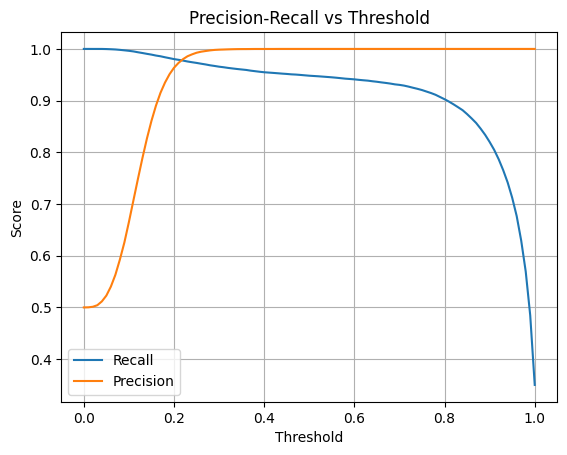

In [37]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(thresholds, recalls[:-1], label="Recall")
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision-Recall vs Threshold")
plt.grid(True)
plt.show()


 XGBOOST basicS
 

In [ ]:
# import xgboost as xgb
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# # Step 1: Prepare the DMatrix (optional, for XGBoost speedup)
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)
# #scale_pos_weight = number of negative samples / number of positive samples in case we have imbalanced data
# # Step 2: Set parameters
# params = {
#     'objective': 'binary:logistic',
#     'eval_metric': 'auc',
#     'scale_pos_weight': 1,
#     'eta': 0.1,
#     'max_depth': 6,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'random_state': 42
# }

# # Step 3: Train model
# bst = xgb.train(params, dtrain, num_boost_round=100)

# # Step 4: Predict
# y_proba = bst.predict(dtest)
# threshold = 0.2  # lower threshold for higher recall
# y_pred = (y_proba >= threshold).astype(int)

# # Step 5: Evaluate
# print("✅ Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred))

# print("\n📊 Classification Report:")
# print(classification_report(y_test, y_pred))

# print(f"🎯 ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

✅ Confusion Matrix:
[[37645   338]
 [ 2285 35697]]

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     37983
           1       0.99      0.94      0.96     37982

    accuracy                           0.97     75965
   macro avg       0.97      0.97      0.97     75965
weighted avg       0.97      0.97      0.97     75965

🎯 ROC AUC Score: 0.9736


In [ ]:
# #hyperparameter tuning
# from imblearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import make_scorer, recall_score, precision_score, fbeta_score, classification_report, confusion_matrix
# from xgboost import XGBClassifier
# import matplotlib.pyplot as plt
# import numpy as np
# X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
#     X_bal, y_bal, test_size=0.1, stratify=y_bal, random_state=42
# )

# # 3. Build pipeline
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),
#     ('smote', SMOTE(random_state=42)),
#     ('xgb', XGBClassifier(
#         use_label_encoder=False,
#         eval_metric='logloss',
#         random_state=42,
#         n_jobs=-1
#     ))
# ])

# # 4. Define parameter grid
# param_grid = {
#     'xgb__n_estimators': [100, 200, 300],
#     'xgb__max_depth': [4, 6],
#     'xgb__learning_rate': [0.01, 0.05],
#     'xgb__subsample': [0.8, 1.0],
#     'xgb__colsample_bytree': [0.8, 1.0],
#     'xgb__scale_pos_weight': [1, 5, 10],
# }

# # 5. Custom F-beta scorer (recall emphasis)
# f2_scorer = make_scorer(fbeta_score, beta=2)

# # 6. Grid search with Stratified K-Fold
# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# grid = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     scoring=f2_scorer,
#     cv=cv,
#     n_jobs=-1,
#     verbose=2
# )

# # 7. Fit grid search
# grid.fit(X_train_split, y_train_split)

# # 8. Extract best parameters
# best_params = grid.best_params_
# core_xgb_params = {k.replace('xgb__', ''): v for k, v in best_params.items() if 'xgb__' in k}

# # 9. Train final model (no early stopping)
# final_model = XGBClassifier(
#     use_label_encoder=False,
#     eval_metric='logloss',
#     random_state=42,
#     n_jobs=-1,
#     **core_xgb_params
# )

# final_model.fit(X_bal, y_bal, verbose=True)

# # 10. Optional: Plot training loss if you include eval_set
# # final_model.fit(
# #     X_bal, y_bal,
# #     eval_set=[(X_bal, 'train')],
# #     verbose=True
# # )
# # evals_result = final_model.evals_result()
# # plt.plot(evals_result['train']['logloss'], label='Train')
# # plt.xlabel('Boosting Rounds')
# # plt.ylabel('Log Loss')
# # plt.title('Training Log Loss')
# # plt.legend()
# # plt.show()

# # 11. Test on held-out test data (assume X_test and y_test are defined)
# y_proba = final_model.predict_proba(X_test)[:, 1]
# threshold = 0.2  # Tune as needed
# y_pred = (y_proba >= threshold).astype(int)

# # 12. Evaluation
# print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 144 candidates, totalling 432 fits


c:\Users\kau75421\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\kau75421\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [12:42:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\kau75421\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [12:42:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not us

[[ 7724 30259]
 [   83 37899]]
              precision    recall  f1-score   support

           0       0.99      0.20      0.34     37983
           1       0.56      1.00      0.71     37982

    accuracy                           0.60     75965
   macro avg       0.77      0.60      0.53     75965
weighted avg       0.77      0.60      0.53     75965



In [41]:
import xgboost
print(xgboost.__version__)

2.1.4


In [47]:
#USE LIGHTGBM as an alternative to XGBoost 
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

# --- Load or define your dataset ---
# X = ...  # feature dataframe
# y = ...  # target labels (0 = not fraud, 1 = fraud)

# Example for demonstration:
# df = pd.read_csv("your_dataset.csv")
# X = df.drop(columns="target")
# y = df["target"]

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
     X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# --- LightGBM Classifier ---
model = lgb.LGBMClassifier(
    is_unbalance=True,
    objective='binary',
    boosting_type='gbdt',
    metric='auc',
    learning_rate=0.02,
    num_leaves=64,
    n_estimators=1000,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)

# --- Train the model ---
model.fit(X_train, y_train)

# --- Predict ---
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# --- Evaluation Metrics ---
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# --- Print Results ---
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")


[LightGBM] [Info] Number of positive: 151930, number of negative: 151929
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7643
[LightGBM] [Info] Number of data points in the train set: 303859, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000007
[LightGBM] [Info] Start training from score 0.000007
Confusion Matrix:
[[37983     0]
 [ 2079 35903]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37983
           1       1.00      0.95      0.97     37982

    accuracy                           0.97     75965
   macro avg       0.97      0.97      0.97     75965
weighted avg       0.97      0.97      0.97     75965

Accuracy:  0.9726
Precision: 1.0000
Recall:    0.9453
F1 Score:  0.9719
ROC AUC:   0.9746


In [73]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)

# --- Initial Train/Test Split ---
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, stratify=y_bal, random_state=42
)

# --- Split training data into train + validation for early stopping ---
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42
)

# --- LightGBM Base Model ---
base_model = lgb.LGBMClassifier(
    is_unbalance=False,
    objective='binary',
    boosting_type='gbdt',
    random_state=42,
    n_jobs=-1
)

# --- Hyperparameter Grid ---
param_grid = {
    'num_leaves': [31, 64, 128],
    'learning_rate': [0.01, 0.02, 0.05],
    'n_estimators': [100, 300, 1000],
    'max_depth': [-1, 10, 20]
}

# --- GridSearch with StratifiedKFold ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=cv,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# --- Fit Grid Search on full training data (without validation split) ---
grid_search.fit(X_train_full, y_train_full)

#

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Number of positive: 151930, number of negative: 151929
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7643
[LightGBM] [Info] Number of data points in the train set: 303859, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000007
[LightGBM] [Info] Start training from score 0.000007


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMClassifier(is_unbalance=False, n_jobs=-1,
                                      objective='binary', random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02, 0.05],
                         'max_depth': [-1, 10, 20],
                         'n_estimators': [100, 300, 1000],
                         'num_leaves': [31, 64, 128]},
             scoring='f1', verbose=1)

In [76]:
 #--- Best Model ---
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# --- Retrain best model with early stopping on train+valid ---
best_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
)

# --- Function to evaluate with custom threshold ---
def evaluate_model(model, X, y, threshold=0.5, set_name="Dataset"):
    y_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    print(f"\n--- Evaluation on {set_name} with threshold={threshold} ---")
    print("Confusion Matrix:")
    print(confusion_matrix(y, y_pred))

    print("\nClassification Report:")
    print(classification_report(y, y_pred, zero_division=0))

    print(f"Accuracy:  {accuracy_score(y, y_pred):.4f}")
    print(f"Precision: {precision_score(y, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y, y_pred, zero_division=0):.4f}")
    print(f"F1 Score:  {f1_score(y, y_pred, zero_division=0):.4f}")
    print(f"ROC AUC:   {roc_auc_score(y, y_proba):.4f}")

# --- Evaluate on train, validation and test sets ---
evaluate_model(best_model, X_train, y_train, threshold=0.3, set_name="Train Set")
evaluate_model(best_model, X_valid, y_valid, threshold=0.3, set_name="Validation Set")
evaluate_model(best_model, X_test, y_test, threshold=0.3, set_name="Test Set")

# --- Evaluate again on test set with custom threshold for better recall ---
custom_threshold = 0.3  # Lowering threshold to improve recall
evaluate_model(best_model, X_test, y_test, threshold=custom_threshold, set_name="Test Set (Custom Threshold)")


Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000, 'num_leaves': 128}
[LightGBM] [Info] Number of positive: 121544, number of negative: 121543
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7644
[LightGBM] [Info] Number of data points in the train set: 243087, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500002 -> initscore=0.000008
[LightGBM] [Info] Start training from score 0.000008

--- Evaluation on Train Set with threshold=0.3 ---
Confusion Matrix:
[[121543      0]
 [   586 120958]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    121543
           1       1.00      1.00      1.00    121544

    accuracy                           1.00    243087
   macro avg       1.00      1.00      1.00    243087


In [ ]:
# --- Set Custom Threshold ---
threshold = 0.3

# Predict on Test
y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= threshold).astype(int)

# Predict on Train
y_train_proba = best_model.predict_proba(X_train)[:, 1]
y_train_pred = (y_train_proba >= threshold).astype(int)

# --- Evaluation on Train ---
print("====== TRAIN SET ======")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

# --- Evaluation on Test ---
print("\n====== TEST SET ======")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

====== TRAIN SET ======

Confusion Matrix:
[[37976     7]
 [ 2044 35938]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37983
           1       1.00      0.95      0.97     37982

    accuracy                           0.97     75965
   macro avg       0.97      0.97      0.97     75965
weighted avg       0.97      0.97      0.97     75965

Accuracy:  0.9730
Precision: 0.9998
Recall:    0.9462
F1 Score:  0.9723
ROC AUC:   0.9758

====== TEST SET ======

Confusion Matrix:
[[37976     7]
 [ 2044 35938]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37983
           1       1.00      0.95      0.97     37982

    accuracy                           0.97     75965
   macro avg       0.97      0.97      0.97     75965
weighted avg       0.97      0.97      0.97     75965

Accuracy:  0.9730
Precision: 0.9998
Recall:    0.9462
F1 Sco

In [4]:
import pandas as pd
df = pd.read_csv(r'C:\Users\kau75421\LLMprojects\CreditFraudDetection\data\processed\Bank_Transaction_Fraud_Detection_Processed.csv')
mv = df.isnull().values.any()

print(mv)

False
